# Network Models: Understanding and Implementing Key Generative Models

## Introduction

Network models serve as mathematical frameworks for generating networks with specific structural properties. They help us understand how real-world networks form and evolve, allowing us to:

1. **Generate synthetic networks** with desired characteristics for testing algorithms
2. **Identify underlying mechanisms** that shape empirical networks
3. **Make predictions** about network behavior and evolution
4. **Establish baselines** for comparison with empirical data

In this tutorial, we'll implement and explore three fundamental classes of network models:

- **Random Networks** (Erdős-Rényi and Gilbert models)
- **Small-World Networks** (Watts-Strogatz model)
- **Scale-Free Networks** (Barabási-Albert model)

Each model represents different organizing principles that can be observed in nature and society. By understanding these models, we gain insight into why real networks look and behave the way they do.

In [1]:
import itertools
import random
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

## 1. Python's `random` module

Many network models rely on randomness in their generative algorithms. Python's [random module](https://docs.python.org/3.7/library/random.html) provides four key functions of use when coding network models.

### `random.random`

Often in an algorithm, we need something to happen with some probability $p$. The canonical way to decide whether or not such an event happens is to generate a random number $r$ between 0 and 1, and if $r < p$, then the event occurs. The [random.random()](https://docs.python.org/3.7/library/random.html#random.random) function returns just such a random number in the interval [0, 1).

For a simple example, consider an unfair coin that comes up heads 75% of the time. We can write the following code to flip such a coin 10 times, reporting the outcome each time:

In [2]:
p = 0.75

# Do this 10 times
for _ in range(10):
    r = random.random()
    if r < p:
        print('Heads')
    else:
        print('Tails')

Heads
Heads
Heads
Heads
Heads
Heads
Tails
Heads
Heads
Heads


As we would expect from a random process, executing the previous cell again will generate a different sequence of flips -- each one is independently generated.

###  `random.choice`

When we have a population of discrete choices and we need to select one at random, we use [random.choice()](https://docs.python.org/3.7/library/random.html#random.choice). For example, instead of "[eeny, meeny, miny, moe](https://en.wikipedia.org/wiki/Eeny,_meeny,_miny,_moe)," we can use random.choice to choose a random name:

In [3]:
names = ['Alice', 'Bob', 'Cathy', 'Dan']
random.choice(names)

'Bob'

### `random.sample`

If we have a collection and we need to select more than one element without replacement, we use [random.sample()](https://docs.python.org/3.7/library/random.html#random.sample). For example, to choose two nodes at random from the nodes in a graph, we can use the following:

In [4]:
G = nx.cycle_graph(10)
random.sample(list(G.nodes), 2)

[3, 8]

### `random.choices`

We use [random.choices()](https://docs.python.org/3.7/library/random.html#random.choices) when we need to choose an element from a collection when the chances of selecting each element are not identical.

For an example, let's assume Alice, Bob, and Carol are in a raffle drawing. Alice bought one ticket, Bob bought three tickets, and Carol bought four tickets. We can simulate ten different draws of this raffle, replacing the drawn ticket each time, with the following code:

In [5]:
names = ['Alice', 'Bob', 'Carol']
tickets = [1, 3, 4]

for _ in range(10):
    print(random.choices(names, tickets))

['Carol']
['Carol']
['Carol']
['Carol']
['Bob']
['Bob']
['Bob']
['Carol']
['Carol']
['Bob']


Running the above cell should give what we expect: Carol wins the drawing most often, with Bob winning some times, and Alice winning occasionally. Of course this outcome depends on the luck of the draw!

By specifying the keyword argument `k=`, we can choose *k* items from the collection *with replacement*:

In [6]:
random.choices(names, tickets, k=10)

['Bob', 'Bob', 'Bob', 'Carol', 'Alice', 'Bob', 'Bob', 'Bob', 'Bob', 'Alice']

The weights provided to `random.choices` do not have to be integers -- any numeric weights are fine.

## 2. Random Network Models

Random networks were among the first mathematical models proposed for studying complex networks. They serve as important null models against which other network structures can be compared.

### Key Characteristics of Random Networks

- **Poisson degree distribution**: Most nodes have degrees close to the average
- **Low clustering coefficient**: The probability that two neighbors of a node are connected is simply p
- **Small average path length**: Distances between nodes grow logarithmically with network size
- **No community structure**: Connections are uniformly random throughout the network

### Two Equivalent Formulations

There are two equivalent ways to formulate random networks:

1. **G(n,p) Model (Gilbert)**: Each possible edge exists with probability p
2. **G(n,m) Model (Erdős-Rényi)**: Exactly m edges are placed randomly

While these models generate statistically similar networks (when m ≈ p·[n(n-1)/2]), the algorithms for creating them differ.

### Generating combinations

We've previously looped over all nodes in a graph, as well as all graph edges, but this algorithm requires us to loop over all *pairs* of nodes, *i.e.* all possible edges. The `itertools` module in Python's standard library gives us the [combinations()](https://docs.python.org/3.7/library/itertools.html#itertools.combinations) function, an elegant way to loop over pairs of elements in a sequence:

In [7]:
elements = [0, 1, 2, 3, 4]
list(itertools.combinations(elements, 2))

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 3),
 (2, 4),
 (3, 4)]

The second argument to `itertools.combinations()` is the length of the sequences we want in the output. Since we want pairs, we'll specify 2. Note the nice properties of the output:

1. No repeat elements -- we don't want to consider self-loops like `('a', 'a')`.
2. Pairs are in sorted order -- `('a', 'b')` and `('b', 'a')` are the same edge in an undirected graph.

We can thus use this to loop over all pairs of nodes in a graph:

In [8]:
G = nx.Graph()
G.add_nodes_from(elements)

list(itertools.combinations(G.nodes, 2))

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 3),
 (2, 4),
 (3, 4)]

### Gilbert Random Graph Model G(n,p)

In the G(n,p) model, we create a network with n nodes where each possible edge exists with probability p. This process creates networks with a binomial degree distribution (approximating Poisson for large networks and small p).

#### Algorithm:
1. Create n nodes
2. For each possible node pair (i,j), add an edge with probability p

In [9]:
def gnp_random_graph(N, p):
    G = nx.Graph()
    G.add_nodes_from(range(N))
    
    for i, j in itertools.combinations(G.nodes, 2):
        r = random.random()
        if r < p:
            G.add_edge(i, j)
        # Do nothing if r >= p
        
    return G

Let's generate several G(n,p) networks with different p values to see how edge density affects network structure. We'll use n=100 nodes and vary p:

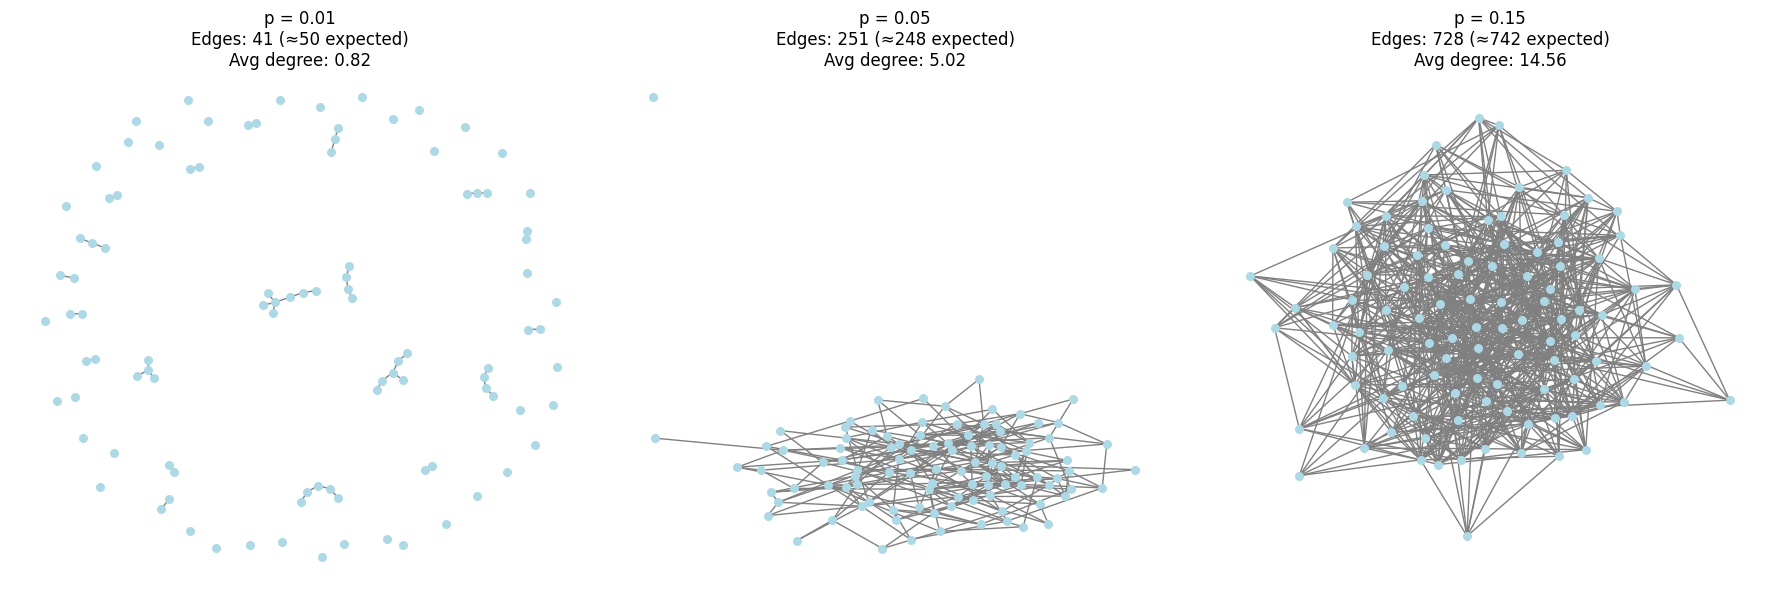

In [10]:
# Visualize multiple G(n,p) networks with different p values
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
p_values = [0.01, 0.05, 0.15]
n_nodes = 100

for i, p in enumerate(p_values):
    G = gnp_random_graph(n_nodes, p)
    expected_edges = p * (n_nodes * (n_nodes - 1) // 2)
    actual_edges = G.number_of_edges()
    
    # Calculate average degree
    avg_degree = 2 * actual_edges / n_nodes
    
    # Draw the graph
    ax = axes[i]
    pos = nx.spring_layout(G, seed=42)  # Consistent layout
    nx.draw(G, pos, ax=ax, node_size=30, node_color='lightblue', edge_color='gray')
    ax.set_title(f'p = {p}\nEdges: {actual_edges} (≈{expected_edges:.0f} expected)\nAvg degree: {avg_degree:.2f}')
    
plt.tight_layout()
plt.show()

### Erdös-Rényi Random Graph Model G(n,m)

In the G(n,m) model, we create a network with n nodes and exactly m edges placed randomly. This approach gives us precise control over the edge count.

#### Algorithm:
1. Create n nodes
2. Select m distinct pairs of nodes uniformly at random
3. Add edges between each selected pair

In [11]:
def gnm_random_graph(N, M):
    G = nx.Graph()
    G.add_nodes_from(range(N))
    
    possible_edges = itertools.combinations(G.nodes, 2)
    edges_to_add = random.sample(list(possible_edges), M)
    G.add_edges_from(edges_to_add)
    
    return G

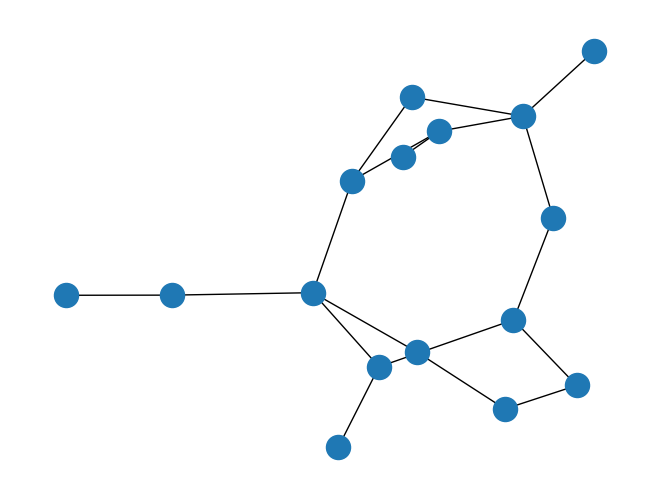

In [12]:
G = gnm_random_graph(16, 18)
nx.draw(G)

#### Mathematical Properties of Random Networks

Random networks show interesting phase transitions as parameters change:

- **Emergence of a giant component**: When average degree exceeds 1 (p > 1/n), a giant connected component forms
- **Connectivity threshold**: When average degree exceeds ln(n) (p > ln(n)/n), the network becomes fully connected

These thresholds are critically important in percolation theory and have applications in epidemic modeling, infrastructure robustness, and information diffusion.

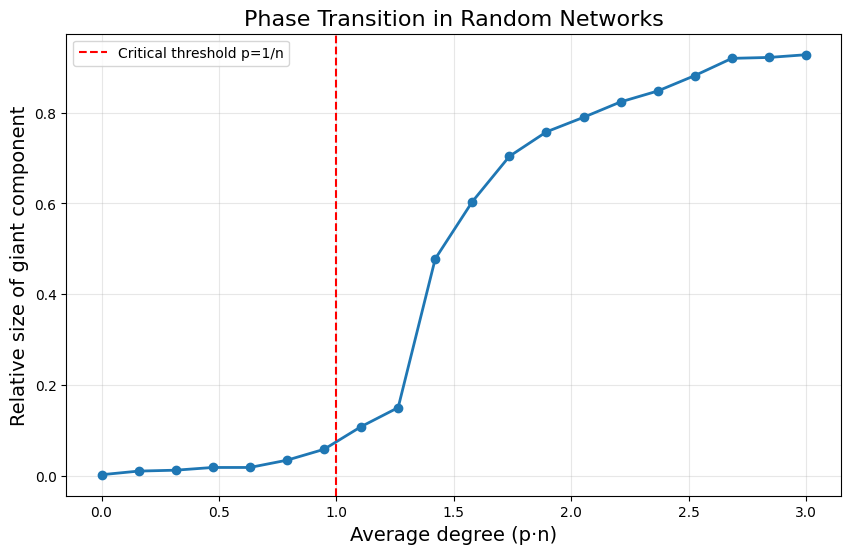

In [13]:
# Demonstrate the emergence of the giant component
n_nodes = 500
p_values = np.linspace(0, 3/n_nodes, 20)  # Range around critical threshold p = 1/n
component_sizes = []

for p in p_values:
    G = nx.gnp_random_graph(n_nodes, p, seed=42)
    if G.number_of_nodes() > 0:  # Ensure graph is not empty
        components = list(nx.connected_components(G))
        if components:  # Ensure there are components
            largest = max(components, key=len)
            component_sizes.append(len(largest) / n_nodes)  # Relative size of largest component
        else:
            component_sizes.append(0)
    else:
        component_sizes.append(0)

plt.figure(figsize=(10, 6))
plt.plot(p_values * n_nodes, component_sizes, 'o-', linewidth=2)
plt.axvline(x=1, color='r', linestyle='--', label='Critical threshold p=1/n')
plt.grid(True, alpha=0.3)
plt.xlabel('Average degree (p·n)', fontsize=14)
plt.ylabel('Relative size of giant component', fontsize=14)
plt.title('Phase Transition in Random Networks', fontsize=16)
plt.legend()
plt.show()

## 3. Small-World Networks

### The Small-World Phenomenon

The small-world phenomenon refers to the observation that most nodes in a network can be reached from every other node by a surprisingly small number of steps, despite having a highly clustered structure. This is popularly known as "six degrees of separation" in social networks.

Real-world networks often exhibit two properties that seem contradictory:

1. **High clustering coefficient**: Nodes tend to form tight-knit groups (like social circles)
2. **Low average path length**: Any two nodes can be reached in a few steps

Random networks have short paths but low clustering, while regular lattices have high clustering but long paths. The Watts-Strogatz model bridges this gap, creating networks with both properties.

### Watts-Strogatz Small-World Model

The Watts-Strogatz model uses a simple mechanism of "rewiring" to introduce randomness to an ordered structure:

#### Algorithm:
1. Start with a regular ring lattice where each node connects to k nearest neighbors
2. For each edge (u,v), with probability p, rewire it to connect u with a randomly chosen node w

The parameter p controls the network's randomness, creating a spectrum between order (p=0) and disorder (p=1).

Let's start by creating a simple ring lattice as our foundation:

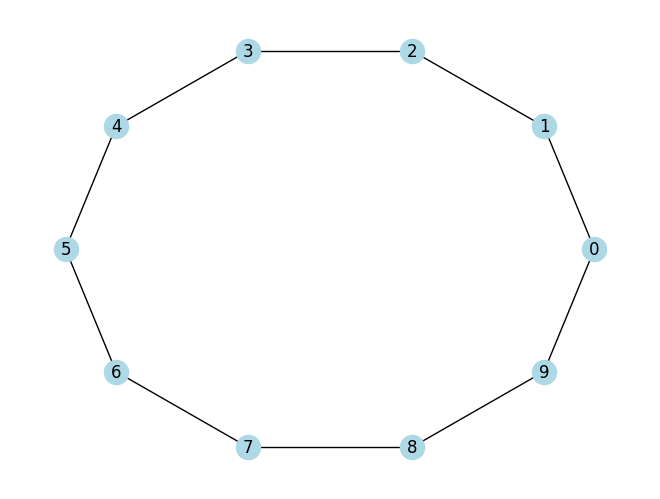

In [14]:
N = 10
G = nx.cycle_graph(N)
nx.draw_circular(G, with_labels=True, node_color='lightblue')

### Connect each node to its $k$ nearest neighbors

Now we'll extend our basic ring (which only connects immediate neighbors) to connect each node to its $k$ nearest neighbors in both directions. For example, if $k$ is 4, node $n$ will connect to: $n-2, n-1, n+1, n+2$.

Since our nodes are arranged in a circle, these connections "wrap around", e.g., the 4 nearest neighbors of node 0 in a 10-node network would be nodes 8, 9, 1, and 2.

Note the use of integer division (//) below. Integer division throws away the fractional part of division, e.g.

    5 // 2 = 2

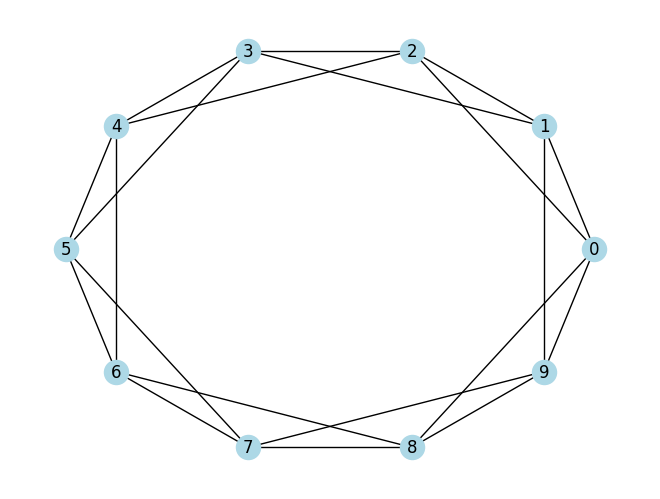

In [15]:
k = 4

for n in G.nodes:
    for i in range(1, k // 2 + 1):
        left  = (n-i) % N
        right = (n+i) % N 
        G.add_edge(n, left)
        G.add_edge(n, right)

nx.draw_circular(G, with_labels=True, node_color='lightblue')

### Rewire some edges

> For each edge $(u, v)$, with probability $p$, replace edge $(u, v)$ with (u, w) where $w$ is not a neighbor of $u$.

For this step, we make use of set arithmetic in order to generate a list of nodes that are not neighbors of $u$, and `random.choice` to select $w$ at random from that set of "not neighbors."

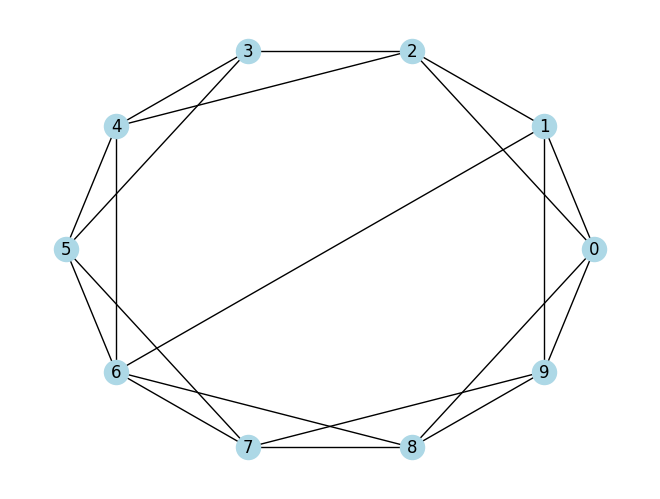

In [16]:
p = 0.1

for u, v in list(G.edges):
    if random.random() < p:
        not_neighbors = set(G.nodes) - set(G.neighbors(u))
        w = random.choice(list(not_neighbors))
        G.remove_edge(u, v)
        G.add_edge(u, w)

nx.draw_circular(G, with_labels=True, node_color='lightblue')

### Watts-Strogatz Small-World Model

We can put this together to write a basic function for the small-world model:

In [17]:
def watts_strogatz_graph(N, k, p):
    # 1. Create a ring of N nodes
    G = nx.cycle_graph(N)

    # 2. Connect each node n to k nearest neighbors
    #    [n-(k//2), ... , n-1, n+1, ... , n+(k//2)]
    for n in G.nodes:
        for i in range(1, k // 2 + 1):
            left  = (n-i) % N
            right = (n+i) % N 
            G.add_edge(n, left)
            G.add_edge(n, right)
    
    # 3. Rewire edges with probability p
    for u, v in list(G.edges):
        if random.random() < p:
            # Ensure we don't create self-loops by explicitly removing u from potential targets
            not_neighbors = set(G.nodes) - set(G.neighbors(u)) - {u}
            
            # Only rewire if there are valid targets available
            if not_neighbors:
                w = random.choice(list(not_neighbors))
                G.remove_edge(u, v)
                G.add_edge(u, w)
            # If no valid targets, keep the original edge

    return G

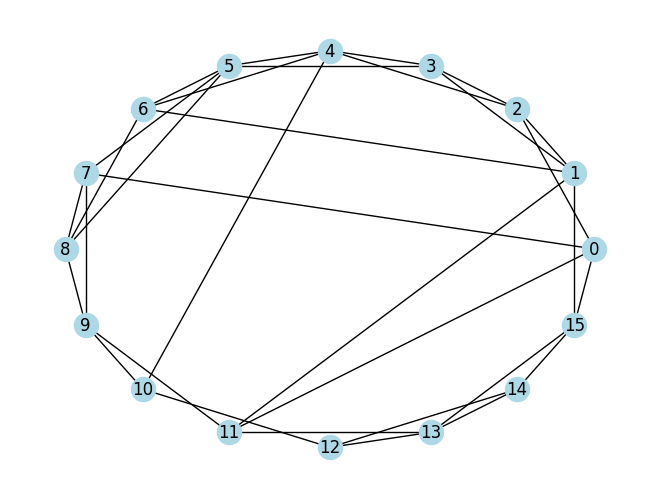

In [18]:
G = watts_strogatz_graph(16, 4, 0.2)
nx.draw_circular(G, with_labels=True, node_color='lightblue')

### NetworkX function

NetworkX has a function for this model: [watts_strogatz_graph()](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.watts_strogatz_graph.html).

### Effect of Rewiring Probability

Let's explore how different rewiring probabilities affect network structure. As p increases, the network transitions from a regular lattice to a more random structure, while maintaining relatively high clustering for small p values.

The most interesting property of the Watts-Strogatz model is the "small-world regime" - a narrow range of rewiring probability where the network maintains high clustering (like a regular lattice) but already has short average path lengths (like a random graph).

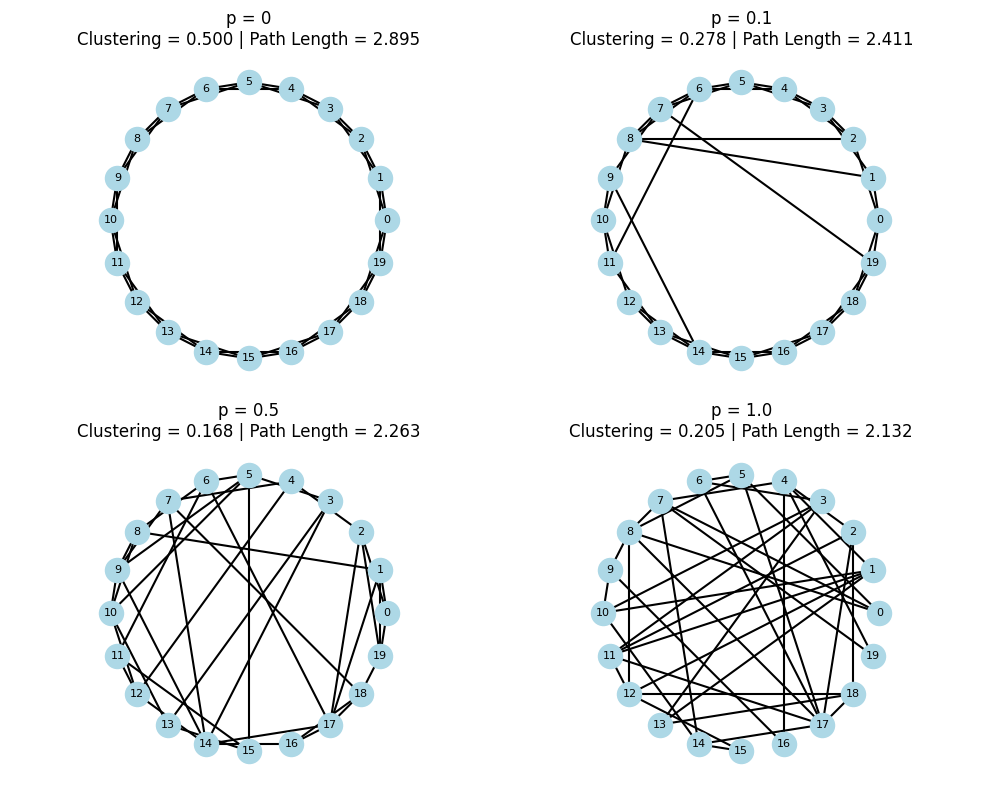

In [19]:
# Demonstrate the effect of different rewiring probabilities
N = 20  # Number of nodes (small for better visualization)
k = 4   # Each node is connected to k nearest neighbors

# Different rewiring probabilities to try
p_values = [0, 0.1, 0.5, 1.0]

# Create subplots arranged in 2 rows and 2 columns for improved layout
fig1, axes1 = plt.subplots(2, 2, figsize=(10, 8))
axes1 = axes1.flatten()  # Flatten to simplify axis iteration

# For storing metrics for each network
avg_clustering = []
avg_path_length = []

# Generate and visualize networks for each rewiring probability
for i, p in enumerate(p_values):
    # Generate a Watts-Strogatz network with the current rewiring probability
    G = nx.watts_strogatz_graph(N, k, p, seed=42)
    
    # Calculate average clustering coefficient and average shortest path length
    clustering = nx.average_clustering(G)
    path_length = nx.average_shortest_path_length(G)
    avg_clustering.append(clustering)
    avg_path_length.append(path_length)
    
    # Use circular layout for better visualization of the network structure
    pos = nx.circular_layout(G)
    nx.draw(G, pos, ax=axes1[i], node_size=300, node_color='lightblue',
            with_labels=True, width=1.5, font_size=8)
    
    # Set subplot title:
    # First line: rewiring probability
    # Second line: both clustering and path length (split into one line for better readability)
    axes1[i].set_title(f'p = {p}\nClustering = {clustering:.3f} | Path Length = {path_length:.3f}')
    axes1[i].axis('equal')  # Ensure equal aspect ratio for the plot

plt.tight_layout()
plt.show()

### Small-World Regime Analysis

Let's examine more closely how the clustering coefficient and average path length change as a function of rewiring probability. This will help us identify the "small-world regime" where we get the best of both worlds: high clustering and short paths.

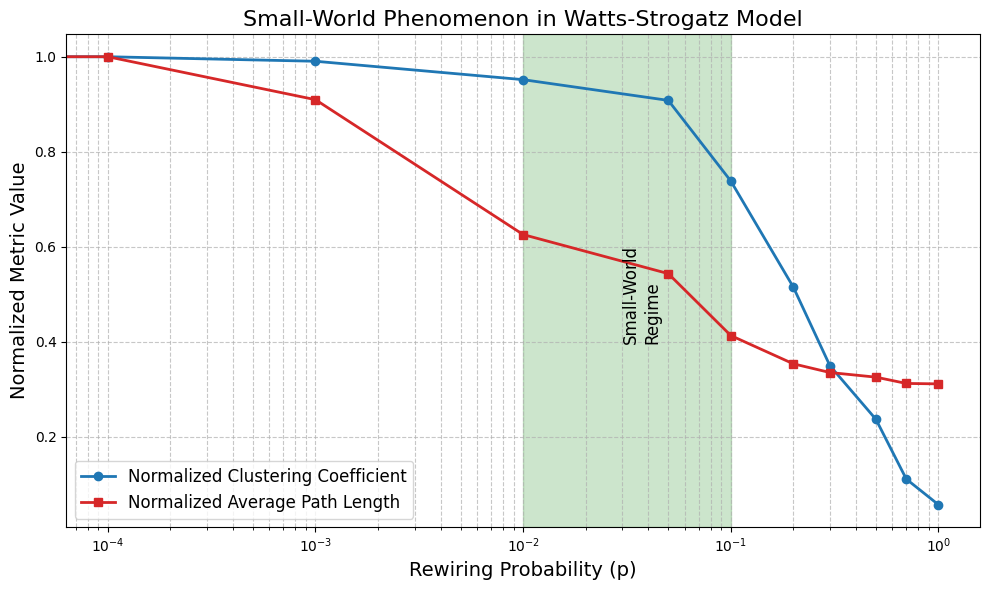

In [20]:
# Create a more detailed analysis with more p values
N = 100  # Larger network for better statistics
k = 6    # Each node connected to 6 nearest neighbors

# More fine-grained p values on a logarithmic scale
p_values = [0, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0]

# Lists to store metrics
clustering_coeffs = []
path_lengths = []
random_clustering = None  # Will store reference value for random graph
random_path_length = None # Will store reference value for random graph
regular_clustering = None # Will store reference value for regular lattice
regular_path_length = None # Will store reference value for regular lattice

# Generate networks and calculate metrics
for p in p_values:
    G = nx.watts_strogatz_graph(N, k, p, seed=42)
    
    # Calculate metrics
    clustering = nx.average_clustering(G)
    path_length = nx.average_shortest_path_length(G)
    
    # Store metrics
    clustering_coeffs.append(clustering)
    path_lengths.append(path_length)
    
    # Store reference values
    if p == 0:  # Regular lattice
        regular_clustering = clustering
        regular_path_length = path_length
    elif p == 1.0:  # Random graph
        random_clustering = clustering
        random_path_length = path_length

# Normalize metrics for comparison
norm_clustering = [c/regular_clustering for c in clustering_coeffs]
norm_path_length = [l/regular_path_length for l in path_lengths]

# Plot normalized metrics
plt.figure(figsize=(10, 6))

plt.plot(p_values, norm_clustering, 'o-', label='Normalized Clustering Coefficient', linewidth=2, color='#1f77b4')
plt.plot(p_values, norm_path_length, 's-', label='Normalized Average Path Length', linewidth=2, color='#d62728')

plt.xscale('log')
plt.xlabel('Rewiring Probability (p)', fontsize=14)
plt.ylabel('Normalized Metric Value', fontsize=14)
plt.title('Small-World Phenomenon in Watts-Strogatz Model', fontsize=16)
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

# Highlight the small-world regime
small_world_min = 0.01
small_world_max = 0.1
plt.axvspan(small_world_min, small_world_max, alpha=0.2, color='green', label='Small-World Regime')
plt.text(0.03, 0.5, 'Small-World\nRegime', rotation=90, fontsize=12, va='center')

plt.tight_layout()
plt.show()

### Understanding the Small-World Phenomenon

The plots above illustrate a key feature of small-world networks: there exists a "sweet spot" in the rewiring probability where:

1. **Path length** has already dropped significantly (approaching random graph levels)
2. **Clustering coefficient** remains high (close to regular lattice levels)

This dramatic difference in how quickly these two properties change with increasing randomness explains why many real-world networks can have both high clustering and short path lengths.

**Key insights:**

- Even a tiny fraction of "shortcut" edges (p ≈ 0.01-0.1) dramatically reduces average path lengths
- Clustering coefficient remains relatively stable until p becomes large (p > 0.1)
- The small-world regime offers an optimal balance between efficient information flow and community structure

Many real-world networks exhibit small-world properties, from neural networks in the brain to social networks and the power grid, suggesting these structures offer evolutionary or design advantages.

## 4. Scale-Free Networks

### Power Laws and Scale-Free Properties

Scale-free networks are characterized by a power-law degree distribution, where the probability of finding a node with k connections follows P(k) ~ k^(-γ), typically with γ between 2 and 3. This creates networks with:

- **Many low-degree nodes**: Most nodes have few connections
- **A few high-degree hubs**: Some nodes have an extremely large number of connections
- **No characteristic scale**: Hence the name "scale-free"

Scale-free networks are ubiquitous in nature and society: the internet, protein interaction networks, citation networks, and many social networks show scale-free properties.

### Mechanisms Behind Scale-Free Networks

Two key mechanisms drive the formation of scale-free networks:

1. **Growth**: The network expands continuously with new nodes joining
2. **Preferential attachment**: New nodes prefer to connect to well-connected existing nodes ("rich get richer")

### Generating Barabási-Albert Scale-Free Networks

Let's explore different ways to create scale-free networks using the Barabási-Albert model in NetworkX. The most important parameter is `m`, which represents the number of edges each new node creates when joining the network.

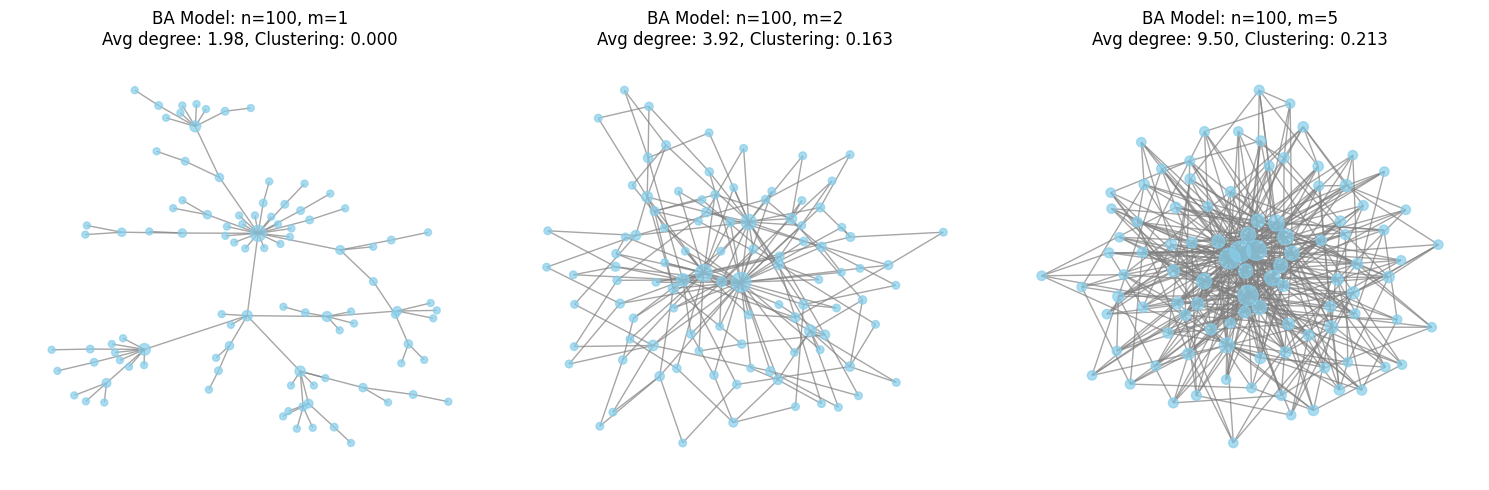

In [21]:
# Basic Barabási-Albert model with different parameters
import networkx as nx
import matplotlib.pyplot as plt

# Parameters to explore
n_values = [100, 100, 100]   # Number of nodes
m_values = [1, 2, 5]         # Number of edges for each new node

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (n, m) in enumerate(zip(n_values, m_values)):
    # Generate BA graph
    G = nx.barabasi_albert_graph(n, m, seed=42)
    
    # Calculate average degree and clustering coefficient
    avg_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
    clustering = nx.average_clustering(G)
    
    # Draw the network
    ax = axes[i]
    pos = nx.spring_layout(G, seed=42)  # Consistent layout
    
    # Size nodes according to their degree to highlight hubs
    node_degrees = dict(G.degree())
    node_sizes = [20 + 5 * node_degrees[node] for node in G.nodes()]
    
    nx.draw_networkx(G, pos, ax=ax, with_labels=False,
                    node_size=node_sizes, node_color='skyblue',
                    edge_color='gray', alpha=0.7)
    
    ax.set_title(f'BA Model: n={n}, m={m}\n'
                f'Avg degree: {avg_degree:.2f}, Clustering: {clustering:.3f}')
    ax.axis('off')

plt.tight_layout()
plt.show()

### Implementing the Barabási-Albert Model from Scratch

To understand the preferential attachment mechanism better, let's implement a simplified version of the Barabási-Albert model from scratch:

In [22]:
def simple_barabasi_albert(n, m, seed=None):
    """Create a Barabási-Albert scale-free graph with simple preferential attachment.
    
    Parameters:
    n : int - The number of nodes
    m : int - Number of edges to attach from a new node to existing nodes
    seed : int - Random seed for reproducibility
    
    Returns:
    G : NetworkX Graph - A Barabási-Albert scale-free graph
    """
    if seed is not None:
        random.seed(seed)
    
    # Start with a complete graph on m nodes
    G = nx.complete_graph(m)
    
    # List of node IDs to select from (with repetition based on degree)
    targets = list(range(m))
    
    # Add n-m additional nodes with preferential attachment
    for source in range(m, n):
        # Select m different nodes according to probability proportional to degree
        new_edges = []
        while len(new_edges) < m:
            # Randomly select a potential target with probability proportional to degree
            target = random.choice(targets)
            if target not in new_edges:  # Avoid duplicate edges
                new_edges.append(target)
        
        # Add edges from new node to selected targets        
        G.add_node(source)
        for target in new_edges:
            G.add_edge(source, target)
            # Add target to the targets list to account for its new edge
            targets.append(target)
        # Add source node to targets list according to its degree (which is m)
        targets.extend([source] * m)
    
    return G

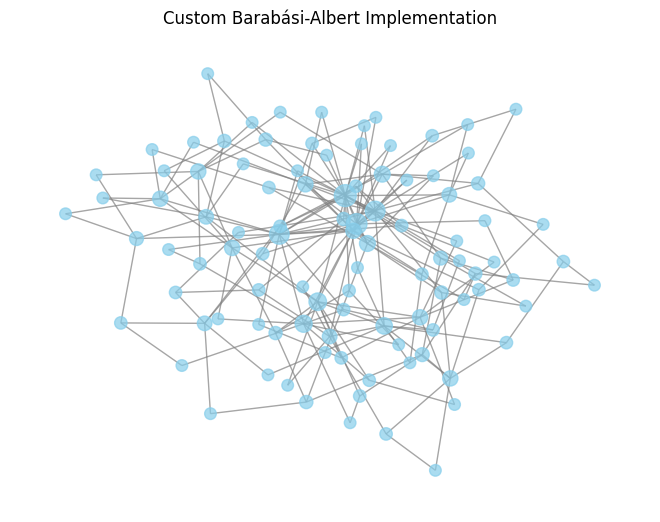

In [23]:
# Test our implementation
G_custom = simple_barabasi_albert(100, 2, seed=42)

plt.figure()
pos = nx.spring_layout(G_custom, seed=42)
node_sizes = [50 + 10 * G_custom.degree(n) for n in G_custom.nodes()]
nx.draw(G_custom, pos, node_size=node_sizes, node_color='skyblue', edge_color='gray', alpha=0.7)
plt.title('Custom Barabási-Albert Implementation')
plt.show()

### Barabási-Albert Preferential Attachment Model

The Barabási-Albert model implements preferential attachment through this algorithm:

1. **Start with a small initial network** (typically a fully connected graph of m nodes)
2. **Growth**: Add one new node at a time
3. **Preferential attachment**: Each new node forms m connections to existing nodes with probability proportional to their degree

This "rich-get-richer" mechanism naturally leads to the emergence of hubs and a power-law degree distribution.

### Visualizing the Preferential Attachment Process

Let's visualize how a BA network grows over time, highlighting the emergence of hubs. We'll create a network step by step and see how certain nodes accumulate more connections.

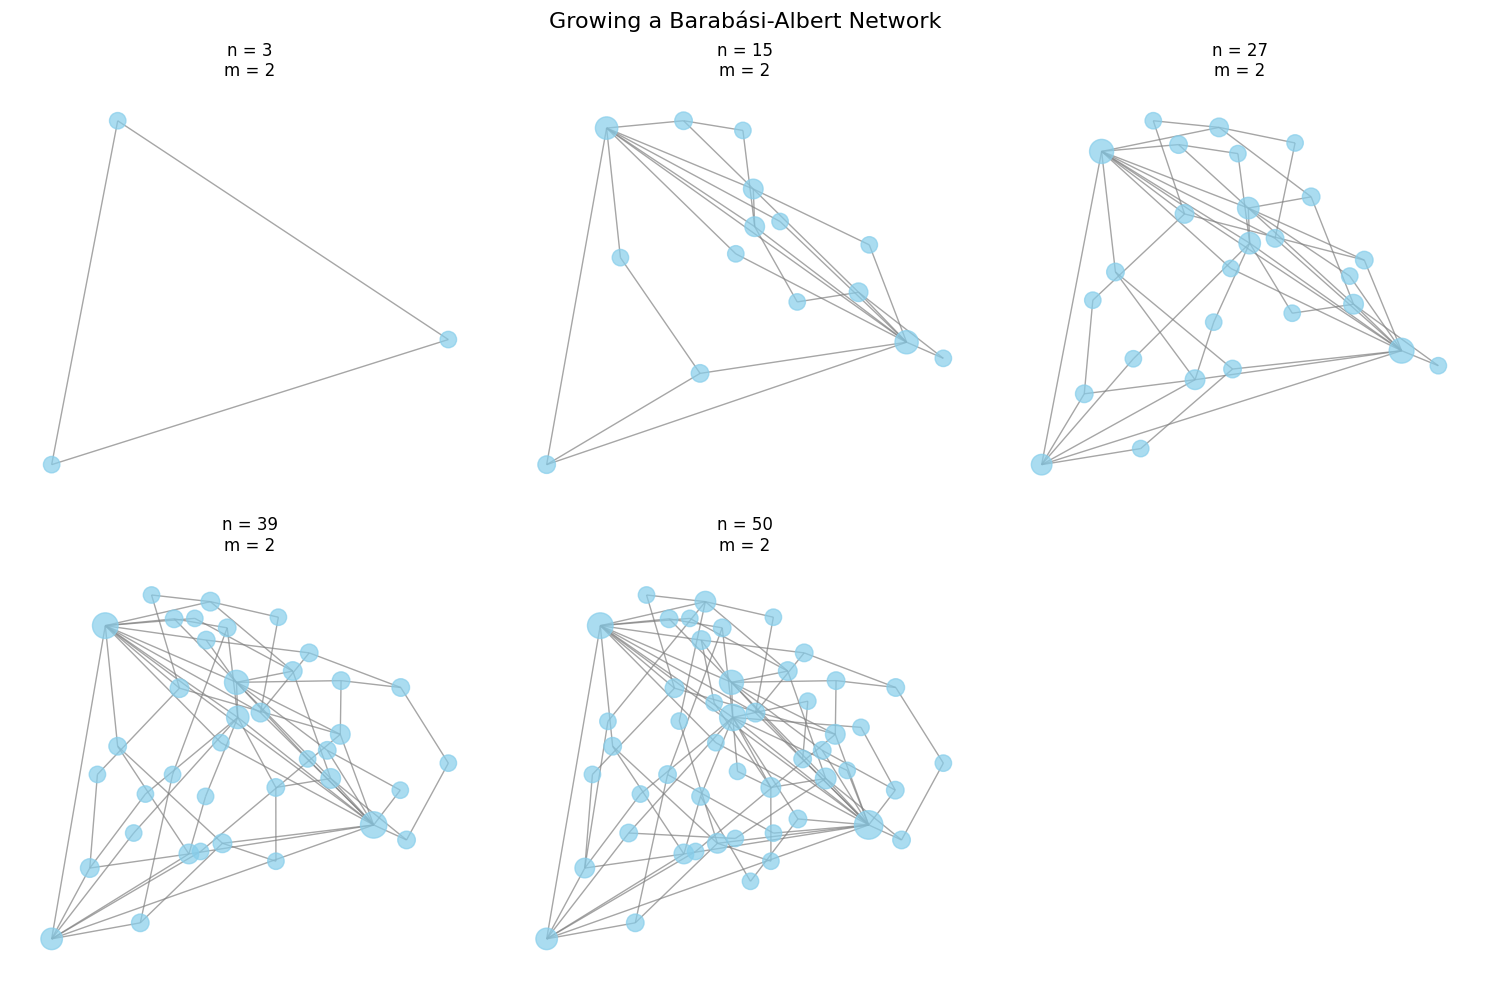

In [24]:
def visualize_ba_growth(n_final=30, m=2, steps=4):
    # Calculate nodes per step
    nodes_per_step = max(1, n_final // steps)
    stages = [m+1] + [min(m+1 + i * nodes_per_step, n_final) for i in range(1, steps)]
    if stages[-1] < n_final:
        stages.append(n_final)
        
    # Arrange the subplots in 2 rows
    rows = 2
    cols = int(np.ceil(len(stages) / rows))
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    axes = axes.flatten()

    # Initialize with a clique
    G = nx.complete_graph(m + 1)
    pos = nx.spring_layout(G, seed=42)  # Initial positions

    for i, n_nodes in enumerate(stages):
        # Grow the network to current size
        while G.number_of_nodes() < n_nodes:
            new_node = G.number_of_nodes()
            # Select m different nodes with preferential attachment
            possible_targets = list(G.nodes())
            targets = []
            for _ in range(m):
                if not possible_targets:  # Safety check
                    break
                weights = [G.degree(node) for node in possible_targets]
                target = random.choices(possible_targets, weights=weights)[0]
                targets.append(target)
                possible_targets.remove(target)
            # Add edges to selected targets
            for target in targets:
                G.add_edge(new_node, target)
        
        # Calculate sizes based on degrees for highlighting hubs
        node_sizes = [100 + 20 * G.degree(node) for node in G.nodes()]
        
        # Update positions for all nodes
        pos = nx.spring_layout(G, pos=pos, fixed=list(pos.keys()), seed=42)
        
        # Draw the network on the respective axis
        ax = axes[i]
        nx.draw(G, pos, ax=ax, node_size=node_sizes, node_color='skyblue',
                edge_color='gray', alpha=0.7)
        ax.set_title(f'n = {G.number_of_nodes()}\nm = {m}')
    
    # Hide any extra subplot axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.suptitle('Growing a Barabási-Albert Network', fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize with different parameters
visualize_ba_growth(n_final=50, m=2, steps=4)

### Degree Distribution in Barabási-Albert Networks

The hallmark of scale-free networks is their power-law degree distribution. Let's verify this by plotting the degree distributions of BA networks with different parameters:

In [25]:
def plot_degree_ccdf(n, m, ax):
    """Generate a BA network with n nodes and m edges per new node,
    and plot the CCDF (Complementary Cumulative Distribution Function)
    of the degree distribution on the provided Axes object."""
    G_ba = nx.barabasi_albert_graph(n, m, seed=42)
    degree_sequence = [d for _, d in G_ba.degree()]
    degree_count = {}
    for d in degree_sequence:
        degree_count[d] = degree_count.get(d, 0) + 1
    unique_degrees = sorted(degree_count.keys())
    total_nodes = G_ba.number_of_nodes()
    ccdf = []
    for k in unique_degrees:
        ccdf.append(sum(count for d, count in degree_count.items() if d >= k) / total_nodes)
    ax.loglog(unique_degrees, ccdf, marker='o', linestyle='-', label=f'm={m} CCDF')

    
def plot_degree_pdf(n, m, ax):
    """Generate a BA network with n nodes and m edges per new node,
    and plot the PDF (Probability Distribution Function)
    of the degree distribution on the provided Axes object."""
    G_ba = nx.barabasi_albert_graph(n, m, seed=42)
    degree_sequence = [d for _, d in G_ba.degree()]
    degree_count = {}
    for d in degree_sequence:
        degree_count[d] = degree_count.get(d, 0) + 1
    unique_degrees = sorted(degree_count.keys())
    total_nodes = G_ba.number_of_nodes()
    pdf = [degree_count[k] / total_nodes for k in unique_degrees]
    ax.loglog(unique_degrees, pdf, marker='s', linestyle='-', label=f'm={m} PDF')

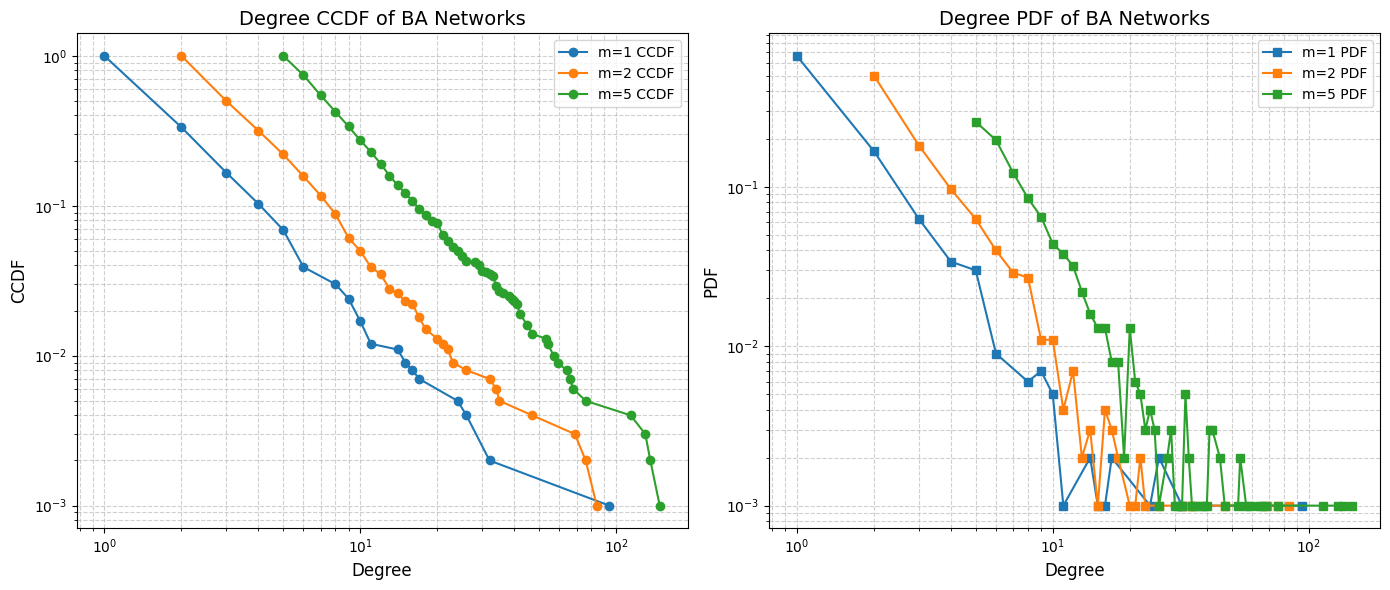

In [26]:
m_values = [1, 2, 5]
n_val = 1000

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

for m in m_values:
    plot_degree_ccdf(n_val, m, ax1)
    plot_degree_pdf(n_val, m, ax2)

# Update titles and labels
ax1.set_title('Degree CCDF of BA Networks', fontsize=14)
ax2.set_title('Degree PDF of BA Networks', fontsize=14)
ax1.set_xlabel('Degree', fontsize=12)
ax1.set_ylabel('CCDF', fontsize=12)
ax2.set_xlabel('Degree', fontsize=12)
ax2.set_ylabel('PDF', fontsize=12)

# Add grid for better readability
ax1.grid(True, which="both", linestyle="--", alpha=0.6)
ax2.grid(True, which="both", linestyle="--", alpha=0.6)

# Update legends' font size
ax1.legend(fontsize=10)
ax2.legend(fontsize=10)

plt.tight_layout()
plt.show()


## 5. Conclusion: Comparing Network Models

We've explored three fundamental classes of network models, each capturing different organizing principles observed in real networks:

| Model | Degree Distribution | Clustering | Path Length | Key Features |
|-------|---------------------|------------|-------------|-------------|
| **Erdős-Rényi** | Poisson | Low | Low | Completely random connections |
| **Watts-Strogatz** | Similar to random | High | Low | Small-world properties, controllable randomness |
| **Barabási-Albert** | Power-law | Medium | Low | Scale-free, hubs, growth and preferential attachment |

### Which Model to Choose?

The choice of network model depends on the properties you want to capture:

- **Random networks** serve as important null models and baselines
- **Small-world networks** are ideal for modeling systems with local clustering but efficient global connectivity
- **Scale-free networks** best represent systems with heterogeneous connectivity patterns and hubs

Understanding these models provides powerful tools for analyzing complex networks across many domains, from social networks to biological systems, information networks, and beyond.